In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods, models
from benchmark.masking_accuracy import MaskedNeuralNetwork, train_masked_network, test_masked_network, MaskedDataset, masking_accuracy
import pickle as pkl
from os import path
import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
dataset_name = "CIFAR10"
batch_size = 64
n_batches = 16
median_value = -.788235  # If set to None, median value will be calculated
model_loc = "models/CIFAR10_masked_cnn.pkl"
data_root = "../data"
load_model = True  # If False, model will be trained on masked data
sample_shape = (3, 32, 32)
normalize_attrs = True

In [4]:
if dataset_name == "CIFAR10":
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"),
                             download=False, shuffle=False, version="cifar10")
    masked_dataset = MaskedDataset(dataset.get_train_data, dataset.get_test_data, radius=5, mask_value=dataset.mask_value, med_of_min=median_value)

Median of minima is -0.788235


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 2)

    def get_logits(self, x):
        relu = nn.ReLU()
        x = self.conv1(x)
        x = relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = relu(x)
        x = self.dropout3(x)
        return self.fc3(x)

    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.float()
        logits = self.get_logits(x)
        return F.softmax(logits, dim=1)

In [6]:
if load_model:
    with open(path.join(data_root, model_loc), "rb") as f:
        model = pkl.load(f)
    test_masked_network(model, masked_dataset)
else:
    model = MaskedNeuralNetwork(sample_shape=sample_shape, mask_radius=5, mask_value=0., net=Net())
    train_masked_network(model, masked_dataset, lr=1.0, gamma=0.7, epochs=2)


Test set: Average loss: 0.3786, Accuracy: 9284/9984 (93%)
Positive samples: 5038/9984 (50%)



In [7]:
attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), normalize=normalize_attrs),
    "Gradient": methods.Gradient(model, normalize=normalize_attrs),
    "InputXGradient": methods.InputXGradient(model, normalize=normalize_attrs),
    "IntegratedGradients": methods.IntegratedGradients(model, normalize=normalize_attrs),
    "GuidedBackprop": methods.GuidedBackprop(model, normalize=normalize_attrs),
    "Deconvolution": methods.Deconvolution(model, normalize=normalize_attrs),
    "Random": methods.Random(normalize=normalize_attrs)
}

In [8]:
results = masking_accuracy(masked_dataset, attribution_methods, n_batches)

Batch 1...


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Batch 2...
Batch 3...
Batch 4...
Batch 5...
Batch 6...
Batch 7...
Batch 8...
Batch 9...
Batch 10...
Batch 11...
Batch 12...
Batch 13...
Batch 14...
Batch 15...
Batch 16...


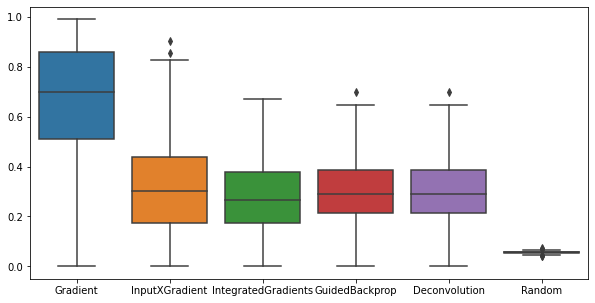

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame.from_dict(results))